In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# importing the data into arrays
# first column of the data file is phase data
TessPhaseHalf = np.loadtxt("GD356allTess.dat", usecols=(0))
TessPhase = np.concatenate((TessPhaseHalf, TessPhaseHalf+1))
# second column of the data file is flux data
TessFluxHalf = np.loadtxt("GD356allTess.dat", usecols=(1))
TessFlux = np.concatenate((TessFluxHalf+1, TessFluxHalf+1))
# third column of the data file is flux error
TessErrorHalf = np.loadtxt("GD356allTess.dat", usecols=(2))
TessError = np.concatenate((TessErrorHalf, TessErrorHalf))

In [3]:
def mean_data(Phase, Flux, Error, bins):

    Phase_split = np.array_split(Phase, bins)
    Flux_split = np.array_split(Flux, bins)
    Error_split = np.array_split(Error, bins)

    meanPhase = [] * bins
    meanFlux = [] * bins
    meanError = [] * bins

    for i in range(bins):

        meanPhase_i = np.mean(Phase_split[i])
        meanFlux_i = np.sum(Flux_split[i] / (Error_split[i]**2))/ np.sum(1/(Error_split[i]**2))

        meanError_i = np.sqrt(1/np.sum(1/(Error_split[i]**2)))

        meanPhase.append(meanPhase_i)
        meanFlux.append(meanFlux_i)
        meanError.append(meanError_i)
        
    return meanPhase, meanFlux, meanError

meanPhase, meanFlux, meanError = mean_data(TessPhase, TessFlux, TessError, 200)

In [75]:
import numpy as np
import starry
import exoplanet as xo
import pymc3 as pm
import pymc3_ext as pmx
import matplotlib.pyplot as plt

starry.config.lazy = True
starry.config.quiet = True

In [5]:
flux = meanFlux/np.amax(meanFlux)
flux_err = np.mean(meanError)/np.amax(meanFlux)
t = meanPhase
theta = np.multiply(meanPhase, 360)

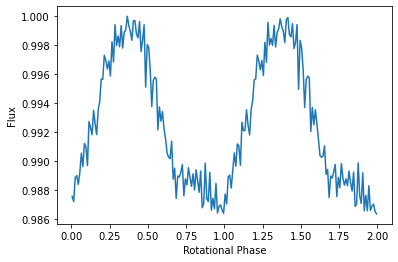

In [6]:
plt.plot(t, flux)
plt.xlabel("Rotational Phase")
plt.ylabel("Flux");

In [81]:
with pm.Model() as model:

    # Priors
    contrast = pm.Uniform("contrast", lower=0.0, upper=1.0, testval=0.5)
    radius = pm.Uniform("radius", lower=0.0, upper=100.0, testval=15.0)
    lat = pm.Uniform("lat", lower=-90.0, upper=90.0, testval=0.1)
    lon = pm.Uniform("lon", lower=-180.0, upper=180.0, testval=0.1)
    inc = pm.Uniform("inc", lower=0.0, upper=90.0, testval=0.1)
    
    
    # Instantiate the map and add the spot
    map = starry.Map(ydeg=30)
    map.inc = inc
    map.spot(contrast=contrast, radius=radius, lat=lat, lon=lon)

    # Compute the flux model
    flux_model = map.flux(theta=theta)
    pm.Deterministic("flux_model", flux_model)

    # Save our initial guess
    flux_model_guess = pmx.eval_in_model(flux_model)

    # The likelihood function assuming known Gaussian uncertainty
    pm.Normal("obs", mu=flux_model, sd=flux_err, observed=flux)

In [82]:
with model:
    map_soln = pmx.optimize(start=model.test_point)

optimizing logp for variables: [inc, lon, lat, radius, contrast]


message: Optimization terminated successfully.
logp: -4078.741889254632 -> 1050.628172344943


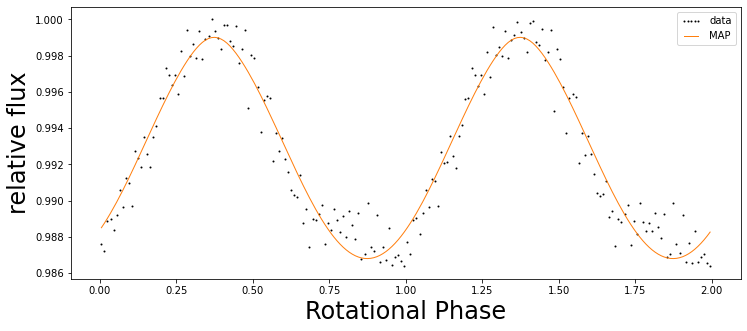

In [83]:
plt.figure(figsize=(12, 5))
plt.plot(t, flux, "k.", alpha=1, ms=2, label="data")
plt.plot(
    t, pmx.eval_in_model(flux_model, map_soln, model=model), "C1-", label="MAP", lw=1
)
plt.legend(fontsize=10, numpoints=5)
plt.xlabel("Rotational Phase", fontsize=24)
plt.ylabel("relative flux", fontsize=24);

In [84]:
keys = ["contrast", "radius", "lat", "lon", "inc"]

In [85]:
print("{0:12s} {1:10s}".format("", "map_soln"))
for key in keys:
    print("{0:10s} {1:10.5f}".format(key, map_soln[key]))

             map_soln  
contrast      0.03283
radius       99.26610
lat         -56.57065
lon          45.41344
inc          33.30971


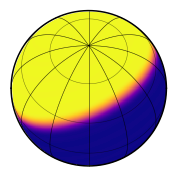

In [18]:
starry.config.lazy = False

map = starry.Map(ydeg=30)
map.spot(contrast=0.03283, radius=99.26610, lat=-56.57065, lon=45.41344)
map.inc = 33.30971
map.show()

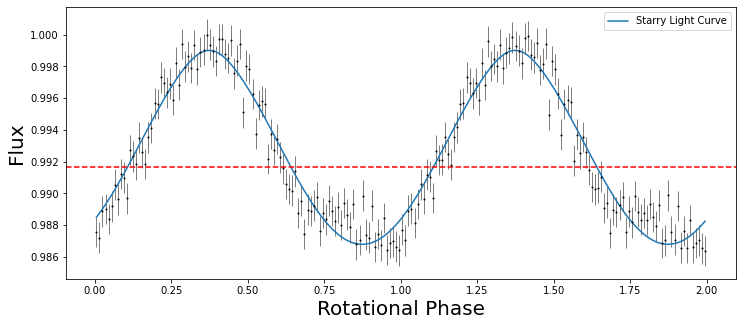

In [19]:
newFlux = map.flux(theta=theta)

plt.figure(figsize=(12, 5))

plt.plot(meanPhase, newFlux, label='Starry Light Curve')
plt.xlabel("Rotational phase", fontsize=20)
plt.legend()
plt.ylabel("Flux", fontsize=20)
plt.errorbar(meanPhase, flux, yerr=meanError, color='black', marker='.', linestyle='none', markersize=2, elinewidth=0.5)
plt.xlabel('Rotational Phase')
plt.ylabel('Flux')
plt.axhline(y=np.median(flux), color='r', linestyle='--');

In [20]:
residuals = (flux - newFlux)/meanError
chi_squared = np.sum(residuals**2)
chi_squared

282.4166997088179

In [23]:
starry.config.lazy = True

with pm.Model() as model:

    # Priors
    contrast = pm.Uniform("contrast", lower=0.0, upper=1.0, testval=0.5)
    radius = pm.Uniform("radius", lower=0.0, upper=40.0, testval=15.0)
    lat = pm.Uniform("lat", lower=-90.0, upper=90.0, testval=0.1)
    lon = pm.Uniform("lon", lower=-180.0, upper=180.0, testval=0.1)
    inc = pm.Uniform("inc", lower=0.0, upper=90.0, testval=0.1)
    
    
    # Instantiate the map and add the spot
    map = starry.Map(ydeg=30)
    map.inc = inc
    map.spot(contrast=contrast, radius=radius, lat=lat, lon=lon)

    # Compute the flux model
    flux_model = map.flux(theta=theta)
    pm.Deterministic("flux_model", flux_model)

    # Save our initial guess
    flux_model_guess = pmx.eval_in_model(flux_model)

    # The likelihood function assuming known Gaussian uncertainty
    pm.Normal("obs", mu=flux_model, sd=flux_err, observed=flux)

In [24]:
with model:
    map_soln = pmx.optimize(start=model.test_point)

optimizing logp for variables: [inc, lon, lat, radius, contrast]


message: Desired error not necessarily achieved due to precision loss.
logp: -4078.1330832225103 -> 1028.7069221722127


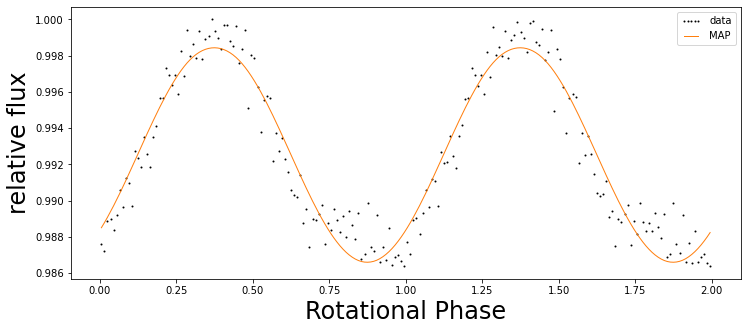

In [25]:
plt.figure(figsize=(12, 5))
plt.plot(t, flux, "k.", alpha=1, ms=2, label="data")
plt.plot(
    t, pmx.eval_in_model(flux_model, map_soln, model=model), "C1-", label="MAP", lw=1
)
plt.legend(fontsize=10, numpoints=5)
plt.xlabel("Rotational Phase", fontsize=24)
plt.ylabel("relative flux", fontsize=24);

In [29]:
param = []
print("{0:12s} {1:10s}".format("", "map_soln"))
for key in keys:
    print("{0:10s} {1:10.5f}".format(key, map_soln[key]))
    param.append(map_soln[key])

             map_soln  
contrast      0.68034
radius        8.12335
lat          47.47296
lon          45.34957
inc          41.11266


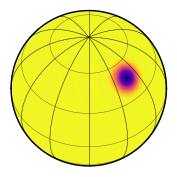

In [28]:
starry.config.lazy = False

map = starry.Map(ydeg=30)
map.spot(contrast=param[0], radius=param[1], lat=param[2], lon=param[3])
map.inc = param[4]
map.show()

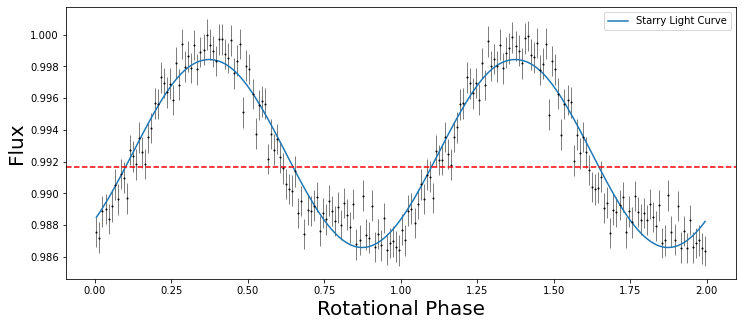

In [30]:
newFlux = map.flux(theta=theta)

plt.figure(figsize=(12, 5))

plt.plot(meanPhase, newFlux, label='Starry Light Curve')
plt.xlabel("Rotational phase", fontsize=20)
plt.legend()
plt.ylabel("Flux", fontsize=20)
plt.errorbar(meanPhase, flux, yerr=meanError, color='black', marker='.', linestyle='none', markersize=2, elinewidth=0.5)
plt.xlabel('Rotational Phase')
plt.ylabel('Flux')
plt.axhline(y=np.median(flux), color='r', linestyle='--');

In [31]:
residuals = (flux - newFlux)/meanError
chi_squared = np.sum(residuals**2)
chi_squared

335.9666679149524

In [32]:
starry.config.lazy = True

with pm.Model() as model:

    # Priors
    contrast = pm.Uniform("contrast", lower=0.0, upper=1.0, testval=0.5)
    radius = pm.Uniform("radius", lower=0.0, upper=90.0, testval=15.0)
    lat = pm.Uniform("lat", lower=-90.0, upper=90.0, testval=0.1)
    lon = pm.Uniform("lon", lower=-180.0, upper=180.0, testval=0.1)
    inc = pm.Uniform("inc", lower=0.0, upper=90.0, testval=0.1)
    
    
    # Instantiate the map and add the spot
    map = starry.Map(ydeg=30)
    map.inc = inc
    map.spot(contrast=contrast, radius=radius, lat=lat, lon=lon)

    # Compute the flux model
    flux_model = map.flux(theta=theta)
    pm.Deterministic("flux_model", flux_model)

    # Save our initial guess
    flux_model_guess = pmx.eval_in_model(flux_model)

    # The likelihood function assuming known Gaussian uncertainty
    pm.Normal("obs", mu=flux_model, sd=flux_err, observed=flux)

In [33]:
with model:
    map_soln = pmx.optimize(start=model.test_point)

optimizing logp for variables: [inc, lon, lat, radius, contrast]


message: Optimization terminated successfully.
logp: -4078.656331366275 -> 1028.028734942098


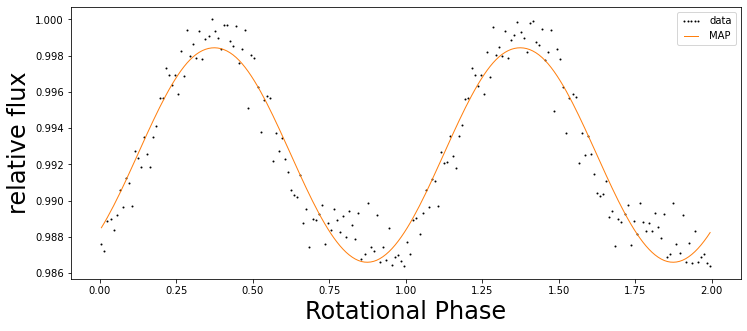

In [34]:
plt.figure(figsize=(12, 5))
plt.plot(t, flux, "k.", alpha=1, ms=2, label="data")
plt.plot(
    t, pmx.eval_in_model(flux_model, map_soln, model=model), "C1-", label="MAP", lw=1
)
plt.legend(fontsize=10, numpoints=5)
plt.xlabel("Rotational Phase", fontsize=24)
plt.ylabel("relative flux", fontsize=24);

In [35]:
param = []
print("{0:12s} {1:10s}".format("", "map_soln"))
for key in keys:
    print("{0:10s} {1:10.5f}".format(key, map_soln[key]))
    param.append(map_soln[key])

             map_soln  
contrast      0.67437
radius        8.15839
lat          47.47122
lon          45.34966
inc          41.11102


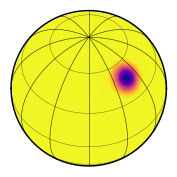

In [36]:
starry.config.lazy = False

map = starry.Map(ydeg=30)
map.spot(contrast=param[0], radius=param[1], lat=param[2], lon=param[3])
map.inc = param[4]
map.show()

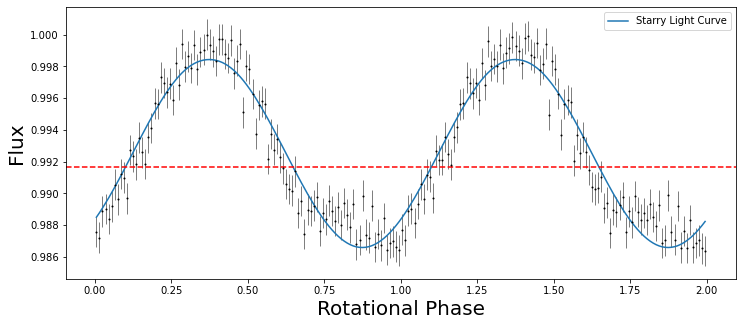

In [37]:
newFlux = map.flux(theta=theta)

plt.figure(figsize=(12, 5))

plt.plot(meanPhase, newFlux, label='Starry Light Curve')
plt.xlabel("Rotational phase", fontsize=20)
plt.legend()
plt.ylabel("Flux", fontsize=20)
plt.errorbar(meanPhase, flux, yerr=meanError, color='black', marker='.', linestyle='none', markersize=2, elinewidth=0.5)
plt.xlabel('Rotational Phase')
plt.ylabel('Flux')
plt.axhline(y=np.median(flux), color='r', linestyle='--');

In [38]:
residuals = (flux - newFlux)/meanError
chi_squared = np.sum(residuals**2)
chi_squared

335.9927502435081

In [39]:
starry.config.lazy = True

with pm.Model() as model:

    # Priors
    contrast = pm.Uniform("contrast", lower=0.0, upper=1.0, testval=0.5)
    radius = pm.Uniform("radius", lower=10.0, upper=90.0, testval=15.0)
    lat = pm.Uniform("lat", lower=-90.0, upper=90.0, testval=0.1)
    lon = pm.Uniform("lon", lower=-180.0, upper=180.0, testval=0.1)
    inc = pm.Uniform("inc", lower=0.0, upper=90.0, testval=0.1)
    
    
    # Instantiate the map and add the spot
    map = starry.Map(ydeg=30)
    map.inc = inc
    map.spot(contrast=contrast, radius=radius, lat=lat, lon=lon)

    # Compute the flux model
    flux_model = map.flux(theta=theta)
    pm.Deterministic("flux_model", flux_model)

    # Save our initial guess
    flux_model_guess = pmx.eval_in_model(flux_model)

    # The likelihood function assuming known Gaussian uncertainty
    pm.Normal("obs", mu=flux_model, sd=flux_err, observed=flux)

In [40]:
with model:
    map_soln = pmx.optimize(start=model.test_point)

optimizing logp for variables: [inc, lon, lat, radius, contrast]


message: Optimization terminated successfully.
logp: -4079.51937758363 -> 1024.7678297795462


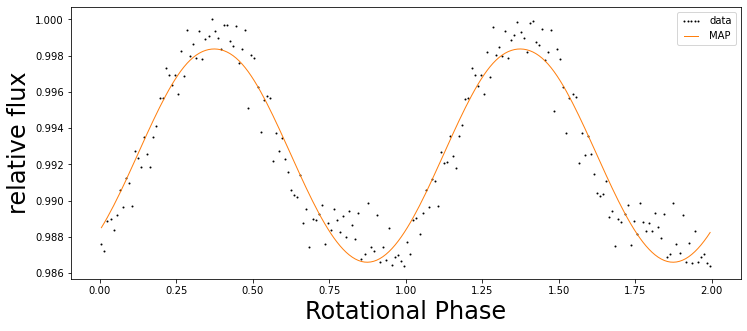

In [41]:
plt.figure(figsize=(12, 5))
plt.plot(t, flux, "k.", alpha=1, ms=2, label="data")
plt.plot(
    t, pmx.eval_in_model(flux_model, map_soln, model=model), "C1-", label="MAP", lw=1
)
plt.legend(fontsize=10, numpoints=5)
plt.xlabel("Rotational Phase", fontsize=24)
plt.ylabel("relative flux", fontsize=24);

In [42]:
param = []
print("{0:12s} {1:10s}".format("", "map_soln"))
for key in keys:
    print("{0:10s} {1:10.5f}".format(key, map_soln[key]))
    param.append(map_soln[key])

             map_soln  
contrast      0.35018
radius       11.28207
lat          47.31375
lon          45.35872
inc          40.97148


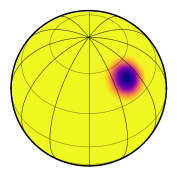

In [43]:
starry.config.lazy = False

map = starry.Map(ydeg=30)
map.spot(contrast=param[0], radius=param[1], lat=param[2], lon=param[3])
map.inc = param[4]
map.show()

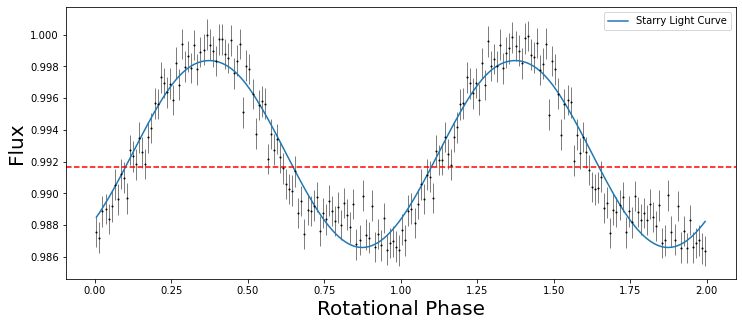

In [44]:
newFlux = map.flux(theta=theta)

plt.figure(figsize=(12, 5))

plt.plot(meanPhase, newFlux, label='Starry Light Curve')
plt.xlabel("Rotational phase", fontsize=20)
plt.legend()
plt.ylabel("Flux", fontsize=20)
plt.errorbar(meanPhase, flux, yerr=meanError, color='black', marker='.', linestyle='none', markersize=2, elinewidth=0.5)
plt.xlabel('Rotational Phase')
plt.ylabel('Flux')
plt.axhline(y=np.median(flux), color='r', linestyle='--');

In [45]:
residuals = (flux - newFlux)/meanError
chi_squared = np.sum(residuals**2)
chi_squared

339.22943685969653

In [48]:
starry.config.lazy = True

with pm.Model() as model:

    # Priors
    contrast = pm.Uniform("contrast", lower=0.0, upper=0.5, testval=0.3)
    radius = pm.Uniform("radius", lower=0.0, upper=90.0, testval=15.0)
    lat = pm.Uniform("lat", lower=-90.0, upper=90.0, testval=0.1)
    lon = pm.Uniform("lon", lower=-180.0, upper=180.0, testval=0.1)
    inc = pm.Uniform("inc", lower=0.0, upper=90.0, testval=0.1)
    
    
    # Instantiate the map and add the spot
    map = starry.Map(ydeg=30)
    map.inc = inc
    map.spot(contrast=contrast, radius=radius, lat=lat, lon=lon)

    # Compute the flux model
    flux_model = map.flux(theta=theta)
    pm.Deterministic("flux_model", flux_model)

    # Save our initial guess
    flux_model_guess = pmx.eval_in_model(flux_model)

    # The likelihood function assuming known Gaussian uncertainty
    pm.Normal("obs", mu=flux_model, sd=flux_err, observed=flux)

In [49]:
with model:
    map_soln = pmx.optimize(start=model.test_point)

optimizing logp for variables: [inc, lon, lat, radius, contrast]


message: Optimization terminated successfully.
logp: -5142.34566001111 -> 1026.7700680444289


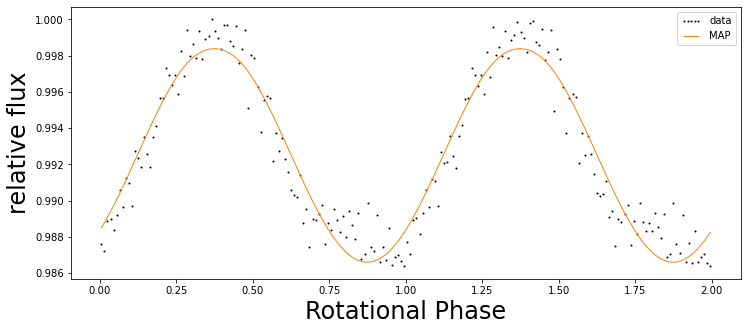

In [50]:
plt.figure(figsize=(12, 5))
plt.plot(t, flux, "k.", alpha=1, ms=2, label="data")
plt.plot(
    t, pmx.eval_in_model(flux_model, map_soln, model=model), "C1-", label="MAP", lw=1
)
plt.legend(fontsize=10, numpoints=5)
plt.xlabel("Rotational Phase", fontsize=24)
plt.ylabel("relative flux", fontsize=24);

In [51]:
param = []
print("{0:12s} {1:10s}".format("", "map_soln"))
for key in keys:
    print("{0:10s} {1:10.5f}".format(key, map_soln[key]))
    param.append(map_soln[key])

             map_soln  
contrast      0.39613
radius       10.60263
lat          47.50367
lon          45.35652
inc          41.14731


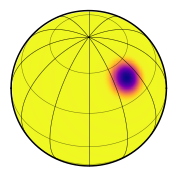

In [52]:
starry.config.lazy = False

map = starry.Map(ydeg=30)
map.spot(contrast=param[0], radius=param[1], lat=param[2], lon=param[3])
map.inc = param[4]
map.show()

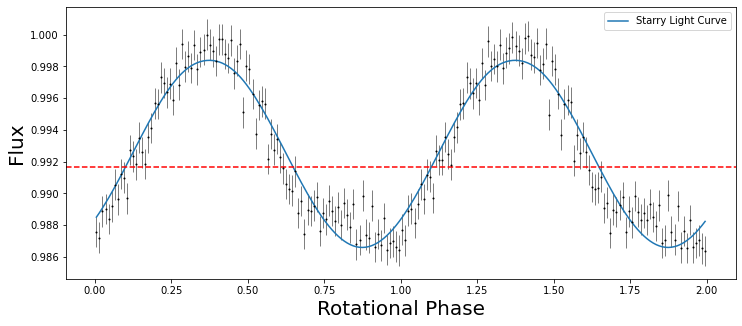

In [53]:
newFlux = map.flux(theta=theta)

plt.figure(figsize=(12, 5))

plt.plot(meanPhase, newFlux, label='Starry Light Curve')
plt.xlabel("Rotational phase", fontsize=20)
plt.legend()
plt.ylabel("Flux", fontsize=20)
plt.errorbar(meanPhase, flux, yerr=meanError, color='black', marker='.', linestyle='none', markersize=2, elinewidth=0.5)
plt.xlabel('Rotational Phase')
plt.ylabel('Flux')
plt.axhline(y=np.median(flux), color='r', linestyle='--');

In [54]:
residuals = (flux - newFlux)/meanError
chi_squared = np.sum(residuals**2)
chi_squared

338.35763527059663

In [86]:
starry.config.lazy = True

with pm.Model() as model:

    # Priors
    contrast = pm.Uniform("contrast", lower=0.0, upper=1.0, testval=0.3)
    radius = pm.Uniform("radius", lower=0.0, upper=100.0, testval=15.0)
    lat = pm.Uniform("lat", lower=-90.0, upper=90.0, testval=0.1)
    lon = pm.Uniform("lon", lower=-180.0, upper=180.0, testval=0.1)
    inc = pm.Uniform("inc", lower=0.0, upper=90.0, testval=0.1)
    
    
    # Instantiate the map and add the spot
    map = starry.Map(ydeg=30)
    map.inc = inc
    map.spot(contrast=contrast, radius=radius, lat=lat, lon=lon)

    # Compute the flux model
    flux_model = map.flux(theta=theta)
    pm.Deterministic("flux_model", flux_model)

    # Save our initial guess
    flux_model_guess = pmx.eval_in_model(flux_model)

    # The likelihood function assuming known Gaussian uncertainty
    pm.Normal("obs", mu=flux_model, sd=flux_err, observed=flux)

In [87]:
with model:
    map_soln = pmx.optimize(start=model.test_point)

optimizing logp for variables: [inc, lon, lat, radius, contrast]


message: Optimization terminated successfully.
logp: -5142.564749292093 -> 1027.933295236518


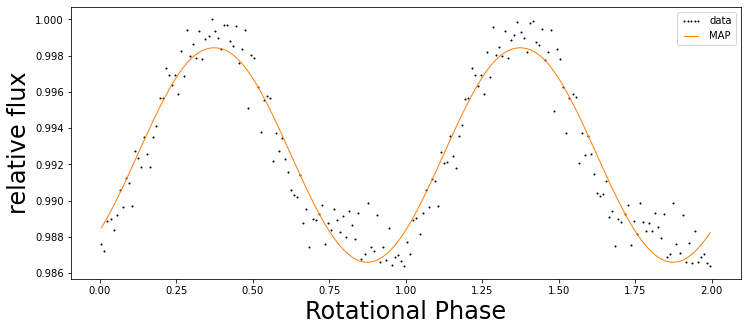

In [88]:
plt.figure(figsize=(12, 5))
plt.plot(t, flux, "k.", alpha=1, ms=2, label="data")
plt.plot(
    t, pmx.eval_in_model(flux_model, map_soln, model=model), "C1-", label="MAP", lw=1
)
plt.legend(fontsize=10, numpoints=5)
plt.xlabel("Rotational Phase", fontsize=24)
plt.ylabel("relative flux", fontsize=24);

In [89]:
param = []
print("{0:12s} {1:10s}".format("", "map_soln"))
for key in keys:
    print("{0:10s} {1:10.5f}".format(key, map_soln[key]))
    param.append(map_soln[key])

             map_soln  
contrast      0.67395
radius        8.16088
lat          47.47110
lon          45.34966
inc          41.11091


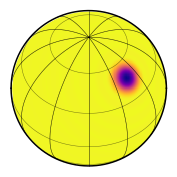

In [71]:
starry.config.lazy = False

map = starry.Map(ydeg=30)
map.spot(contrast=param[0], radius=param[1], lat=param[2], lon=param[3])
map.inc = param[4]
map.show()

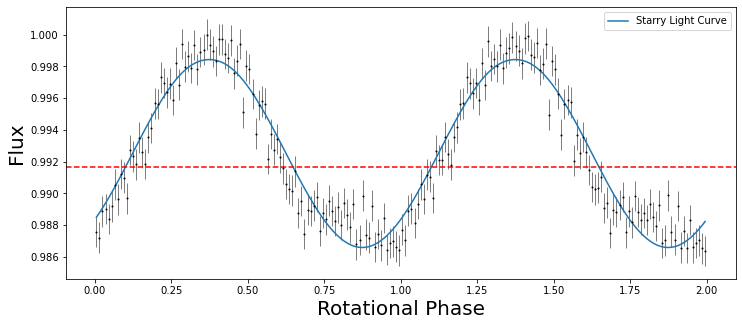

In [72]:
newFlux = map.flux(theta=theta)

plt.figure(figsize=(12, 5))

plt.plot(meanPhase, newFlux, label='Starry Light Curve')
plt.xlabel("Rotational phase", fontsize=20)
plt.legend()
plt.ylabel("Flux", fontsize=20)
plt.errorbar(meanPhase, flux, yerr=meanError, color='black', marker='.', linestyle='none', markersize=2, elinewidth=0.5)
plt.xlabel('Rotational Phase')
plt.ylabel('Flux')
plt.axhline(y=np.median(flux), color='r', linestyle='--');

In [73]:
residuals = (flux - newFlux)/meanError
chi_squared = np.sum(residuals**2)
chi_squared

335.99459488637837